# Demo notebook
### Containing text and polyphonic music generation examples

#### First some imports:

In [1]:
# imports:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import theano
import os
import sys
import pickle

from theano import tensor as T

from models.deeprnn import DeepRNN
from utils.utils import process_dataset

plot = plt.plot

%load_ext Cython
%load_ext autoreload
%autoreload 2

%matplotlib inline

Using gpu device 0: GeForce GTX 980 (CNMeM is disabled)


# Text

In [5]:
# form a dictionary between characters and vectors (this is from Keras):
from keras.datasets.data_utils import get_file

path = get_file('nietzsche.txt', origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt")
text = open(path).read().lower()
print('corpus length:', len(text))

chars = set(text)

stripped_chars = {'\n',' ','!','"',"'",'(',')',',','-','.','0','1','2',
                  '3','4','5','6','7','8','9',':',';','?','a','b','c','d',
                  'e','f','g','h','i','j','k','l','m','n','o','p','q','r',
                  's','t','u','v','w','x','y','z'}

print('total chars:', len(stripped_chars))


char_indices = dict((c, i) for i, c in enumerate(stripped_chars))
indices_char = dict((i, c) for i, c in enumerate(stripped_chars))

dataset = np.zeros((len(text), len(stripped_chars)), dtype=theano.config.floatX)
for t, char in enumerate(text):
    if char in stripped_chars:
        dataset[t, char_indices[char]] = 1

text_recon = ''
for row in dataset:
    idx = np.argmax(row)
    text_recon += indices_char[idx]
    
text_file = open("nietzsche_recon.txt", "w")
text_file.write(text_recon)
text_file.close()

corpus length: 600901
total chars: 49


In [6]:
# load trained parameters:
state = 'saved_model_parameters/text_5_10_m0.016'
n_visible = dataset.shape[1]

# Instatiate model:
model = DeepRNN(depth=5,
                 width=10,
                 readout_width=1,
                 readin_layer='tanh',
                 rnn_layer='gru',
                 readout_layer='softmax',
                 n_visible=n_visible,
                 optimizer='adadelta',
                 state_from_file=state,  # set this to 'None' if you want to train from scratch
                 sparsity=1.,
                 readin_input_scale=2.,
                 recurrence_spectral_radius=1.2,
                 recurrence_input_scale=1.,
                 readout_scale=1.,
                 dropout=0.,
                 input_dropout=0.,
                 input_noise=0.)

Loading parameters from file saved_model_parameters/text_5_10_m0.016.save


Train the model by using the cell below, if you want. However, the model is already fully trained so you can just skip that one.

It is in general a good idea to start with learning rate (lr) equal to 1 and then use e.g. 0.1 for fine tuning (even though the optimizer is Adadelta). I also usually start with small batch sizes and then increase those to around 100-200 in later stages. Note that there's and `min_batch_size` and `max_batch_size`, which simply means that the actual batch size varies randomly between those (the idea is to increase the "stochasticity" in SGD, although it's probably not very important). `gamma` is an Adadelta parameter. Hit `ctrl+c` when you've trained enough.

In [8]:
model.train(dataset, 
            lr=.1,                     
            min_batch_size=100,                 
            max_batch_size=250, 
            num_epochs=1000, 
            save_as=state,
            gamma=.95)                 

Sample:      1/1 -- Progress:   0% -- Cost= 0.026 -- Monitor= 0.026
Interrupted by user.


Then we can generate some samples. Feel free to change the `initial_data` string to whatever you want (just remember to use the allowed characters only, i.e. no upper case letters etc.). 

`timesteps` indicates the number of characters generated. Feel free to use larger numbers. The generation is done by `theano.scan`, so it's quite fast even for longer text.

In [9]:
initial_str = 'how many philosophers does it take to change a light bulb?'

initial_data = np.zeros((len(initial_str), len(stripped_chars)), dtype=theano.config.floatX)

for t, char in enumerate(initial_str):
    if char in stripped_chars:
        initial_data[t, char_indices[char]] = 1

generated = model.generate(timesteps=400, 
               initial_data=initial_data)

generated_text = ''

for row in generated:
    idx = np.argmax(row)
    generated_text += indices_char[idx]
    
print(generated_text)

how many philosophers does it take to change a light bulb? and
equality constraintly, the shattering and period. we should really be the right
out of effect perhaps be two kinds of consrious willing under which it we
feels whatever others into a berm disguise (namely, science has
as ivensued in any organic and isolated its associated with which
every one worse, winced and possessing the more into any brought
and fastidious sensus assumes that, slowly, an


#### Post training analysis:

We can check everything's OK with the model by outputting the recurrent hidden unit values as we feed in the input with the `generate_hidden_states` method like this:

In [10]:
hidden_dynamics = model.generate_hidden_states(initial_data, 0., 1.)
hidden_dynamics.shape

(5, 58, 490)

The shape of the `hidden_dynamics` is `(depth, n_visible, n_hidden_recurrent)`. Then we can just plot what goes on e.g. in the last layer:

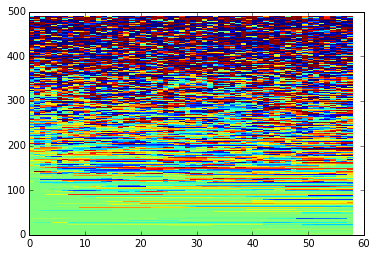

In [12]:
plt.pcolor(hidden_dynamics[-1][:, 0:].T, vmin=-1, vmax=1)

The red and blue colors indicate that there's lots of activity in neurons ~200 and above, while the neurons ~100 and below seem to change only slowly. This is actually intentional, as I initialized the GRU update gate biases to be `linspace(-5, 5, n_hidden_recurrent)`. The point is to "encourage" some neurons to update only slowly, so that the model would perform better at capturing long term dependencies. I basically improvised a bit based on the usual method of inintializing LSTM networks with biases around -5 (see e.g. Schmidhuber et al. CW-RNN paper http://arxiv.org/pdf/1402.3511.pdf), but I wanted some of the neurons to alse remain "fast". Haven't done any real benchmarks to verify that this would improve the end results, but it seemed to do so...

Anyway, the last layer shows rich activity, which is important. For bad initialization parameters and after some learning, it could happen that the last layer activity just settles into an equilibrium state, which would mean that the signal is not being passed to the readout layer. This can especially happen if the readout is the RBM layer. Plotting the highest layer activity is a good way to check if that happens!

# Music

In [41]:
# process data (will create a classics.npz file in the project root):
data_path = "./midi_data/"

dataset_temp = process_dataset(data_path, outname='classics')

File saved as classics.npz


In [20]:
# load the .npz file and drop short songs:
dataset = np.load('classics.npz')['arr_0'].tolist()

new_dataset = []

for n, song in enumerate(dataset):
    if len(song) > 100:
        new_dataset.append(song)
        
dataset = new_dataset

# I actually trained with a slightly smaller dataset:
dataset = dataset[0:50]

In [21]:
# instantiate model:
# note that convergence of training is pretty sensitive to the initial values...
# I should work on those a bit more...
loaded_state = 'saved_model_parameters/all_noninvariant_5_5_m0.037'
state = 'all_noninvariant_5_5'

n_visible = dataset[0].shape[1]

model = DeepRNN(depth=5,
                 width=5,
                 readout_width=1,
                 readin_layer='tanh',
                 rnn_layer='gru',
                 readout_layer='rbm',
                 n_visible=n_visible,
                 optimizer='adadelta',
                 state_from_file=loaded_state,
                 sparsity=.2,
                 readin_input_scale=2.,
                 recurrence_spectral_radius=1.2,
                 recurrence_input_scale=2.,
                 readout_scale=11,  # this is pretty important for convergence of training!
                 dropout=0.,
                 input_dropout=0.,
                 input_noise=0.005)

Loading parameters from file saved_model_parameters/all_noninvariant_5_5_m0.037.save


In [ ]:
# Training as usual. Skip if you just want to evaluate!
model.train(dataset, 
            lr=.1,                     # .1 or 1. !!!
            min_batch_size=100,                 
            max_batch_size=250, 
            num_epochs=100, 
            save_as=state,
            gamma=.95)                 # .9 or .99 !!!

Now we can generate some music. The script below will create a file called 'gru_sample.mid'
in the project root. You can use e.g. the VLC player to play the midi data.

The `generate` method will also plot a "piano roll" of the generated song, with the x-axis showing the timestep and y-axis the note played.

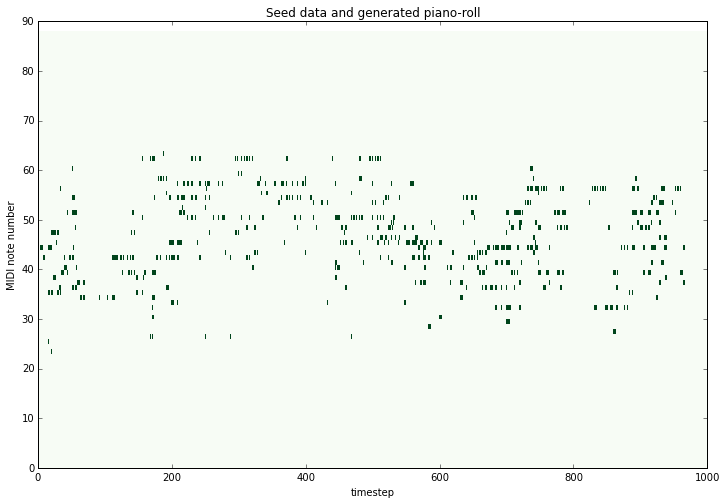

In [26]:
# use these if you want to generate from a seed:
init_time = 40
initial_data = dataset[3][0:0 + init_time]

# starting from no seed:
model.generate('gru_sample', 
               timesteps=1000,
               initial_data=None)

Just as a demo of post training analysis, let's look at the spectrum of the last layer hidden recurrent weight W:

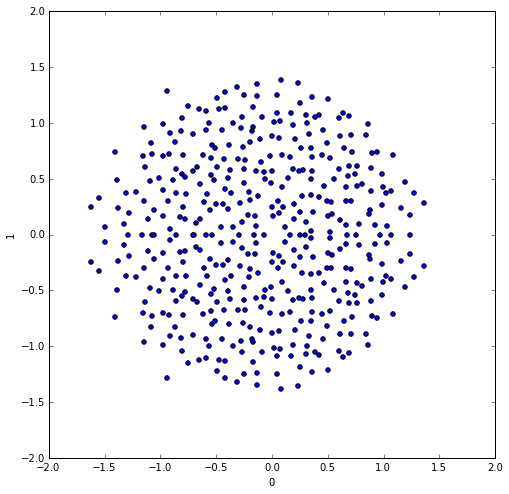

In [39]:
import pandas as pd  # just for convenience...

Wmat = model.parameters[2][-1][:5 * n_visible, :5 * n_visible].eval()

eigvals = np.linalg.eigvals(Wmat)
eigs_re, eigs_im = eigvals.real, eigvals.imag
eigs_as_vec = np.concatenate((eigs_re[:, None], eigs_im[:, None]), axis=1)
eigs_df = pd.DataFrame(eigs_as_vec)

#eigs_df.plot(kind='hexbin', x=0, y=1, gridsize=20)
eigs_df.plot(kind='scatter', x=0, y=1, figsize=(8, 8))

Initially we had `recurrence_spectral_radius=1.2`, which is just the distance of the largest absolute eigenvalue of the matrix `Wmat` from the origin. The inital spectrum is then random uniform inside this radius. We see that the spectrum has evolved into a slightly different shape in every layer.

Anyway, can't think of anything more at the moment, so that's all for now!

So you read this far? Great! Let me know if you get some interesting results using this little module :)